In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_dataset():
    path1 = '../../test/resources/data/results_forecasting'
    path2 = '_java.csv'
    # AutoRegressive Integrated Mooving Averge
    arima = pd.read_csv('{}/Arima{}'.format(path1, path2))
    # Long Short-Term Memory
    lstm_168 = pd.read_csv('{}/Lstm_16x8{}'.format(path1, path2))
    lstm_816 = pd.read_csv('{}/Lstm_8x16{}'.format(path1, path2))
    lstm_1616 = pd.read_csv('{}/Lstm_16x16{}'.format(path1, path2))
    lstm_3216 = pd.read_csv('{}/Lstm_32x16{}'.format(path1, path2))
    # Deep Neural Network
    dnn_168 = pd.read_csv('{}/Dnn_16x8{}'.format(path1, path2))
    dnn_163264 = pd.read_csv('{}/Dnn_16x32x64{}'.format(path1, path2))
    dnn_1616 = pd.read_csv('{}/Dnn_16x16{}'.format(path1, path2))
    
    dataset = [arima, lstm_168, lstm_816, lstm_1616, lstm_3216, dnn_168, dnn_163264, dnn_1616]
    dataname = ['arima', 'lstm_16x8', 'lstm_8x16', 'lstm_16x16', 'lstm_32x16', 'dnn_16x8', 'dnn_16x32x64', 'dnn_16x16']    
    return dataset, dataname

def synthesis(dataset, dataname, string, decim, prin):
    order = False
    if string == 'order_time':
        if prin:
            print('Training time and time of order computing for arima comparaison (seconds) :')
        string = 'training_time'
        order = True
    if (not order) and prin:
        print('{} comparaison '.format(re.sub('_', ' ', string).capitalize()),end='')
        if string[-5:] == '_time':
            print('(seconds) ',end='')
        print(':')
    l = []
    for j in range(len(dataset)):
        cptr = 0
        if string == 'training_time' and dataname[j][-5:] == '_name':
            tmp = []
            for i in range(0, dataset[j].shape[0]):
                if dataset[0].loc[i,'metric_name'] not in tmp:
                    tmp.append(dataset[0].loc[i,'metric_name'])
                    cptr += dataset[j].loc[i,string]
        else:
            for i in range(0, dataset[j].shape[0]):
                if order and  dataname[j][:5] == 'arima':
                    cptr += dataset[j].loc[i,string] + dataset[0].loc[i,'order_time']
                else:
                    cptr += dataset[j].loc[i,string]
        l.append([dataname[j], cptr/dataset[j].shape[0]])
    l = sorted(l, key=lambda cptr: cptr[1])
    if prin:
        l1, l2 = l[:int(len(l)/2)], l[int(len(l)/2):]
        space = '      '
        for tup1, tup2 in zip(l1, l2):
            print('{name:12} : {val:12} {spac} | {spac} {name2:12} : {val2:12}'.format(name=tup1[0], val=round(tup1[1], decim), spac=space, name2=tup2[0], val2=round(tup2[1], decim)))
    return l

def adjust(liste):
    m = liste[-1][1]
    res = []
    for i in range(len(liste)):
        res.append([liste[i][0], (liste[i][1]/m)*100])
    return res
        
def autolabel(ax, rects, liste, n):
    i = 0
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 5+h, '{}'.format(round(liste[i][1], n)),
                ha='center', va='bottom', rotation=90)
        i+=1

# Comparaison id/name temps d'entrainement/RMS
def comp_idName(algo, order_training, mean_squared):
    for liste in order_training:
        if algo.lower() + '_name' == liste[0]:
            order_name = liste[1]
        if algo.lower() + '_id' == liste[0]:
            order_id = liste[1]
    for liste in mean_squared:
        if algo.lower() + '_name' == liste[0]:
            mean_name = liste[1]
        if algo.lower() + '_id' == liste[0]:
            mean_id = liste[1]
    print('\tMean of training time of the {} algorithm :'.format(algo))
    print("{first:55} : {second:5} seconds/metric_id".format(first='Training on each mectric_id', second=round(order_id,2)))
    print("{first:55} : {second:5} seconds/metric_id".format(first='Training on a single metric_id for an entire metri_name', second=round(order_name,2)))
    print('\n\tMean of root mean squared error of the {} algorithm :'.format(algo))
    print("{first:55} : {second:5}".format(first='Training on each mectric_id', second=round(mean_id,2)))
    print("{first:55} : {second:5}".format(first='Training on a single metric_id for an entire metri_name', second=round(mean_name,2)))

    print('\nTraining only on a single metric_id for an entire metri_name is {} time faster,\nbut we are loosing {}% of precision'.format(round(order_id/order_name,2), round(100*mean_name/mean_id,2)))
    
def moustaches(dataset, dataname, string):
    k=0
    fig1, ax1 = plt.subplots(int(len(dataset)/2),2,figsize=(20,12))
    for i in range(len(dataset)):
        ax1[k,(i%2)].set_title('Horizontal Boxes of {}'.format(dataname[i]))
        ax1[k,(i%2)].boxplot(dataset[i][[string]], vert=False)
        if i%2==1:
            k+=1
    fig1.tight_layout()
    plt.show()

def val_extr(data, string):
    aber = []
    for algo in data:
        Q1 = np.quantile(algo[string], 0.25)
        Q3 = np.quantile(algo[string], 0.75)
        EIQ = Q3 - Q1
        lim_inf = Q1 - 1.5*EIQ
        lim_sup = Q3 + 1.5*EIQ
        indx = list(algo[string].index[(algo[string] < lim_inf) | (lim_sup < algo[string])])
        for x in indx:
            if x not in aber:
                aber.append(x)
    for algo in data:
        algo = algo.drop(sorted(aber), axis=0, inplace=True)
    return sorted(aber)

def val_aber(data, string):
    for algo in data:
        Q1 = np.quantile(algo[string], 0.25)
        Q3 = np.quantile(algo[string], 0.75)
        EIQ = Q3 - Q1
        lim_inf = Q1 - 1.5*EIQ
        lim_sup = Q3 + 1.5*EIQ
        indx = list(algo[string].index[(algo[string] < lim_inf) | (lim_sup < algo[string])])
        algo = algo.drop(indx, axis=0, inplace=True)

def root_mean(dataset, dataname):
    fig1, ax1 = plt.subplots(2,1,figsize=(12,8))
    ax1[0].set_title('Root mean squared error of the different methods')
    ax1[1].set_title('Root mean squared error of the different methods with logarithm scale')
    ax1[0].grid(True,which="both", linestyle='--')
    ax1[1].grid(True,which="both", linestyle='--')
    for algo in dataset:
        ax1[0].plot(algo['mean_squared_error'].to_numpy().reshape(-1,1), linewidth=1)
        ax1[1].plot(algo['mean_squared_error'].to_numpy().reshape(-1,1), linewidth=1)
    ax1[1].set_yscale('log')
    fig1.legend(dataname)
    fig1.tight_layout()
    plt.show()
    
def preparation(mean_squared, inference, training):
    adj_mean = adjust(mean_squared)
    adj_infe = adjust(inference)
    adj_train = adjust(training)

    mean_squared = sorted(mean_squared, key=lambda cptr: cptr[0])
    inference = sorted(inference, key=lambda cptr: cptr[0])
    training = sorted(training, key=lambda cptr: cptr[0])
    adj_mean = sorted(adj_mean, key=lambda cptr: cptr[0])
    adj_infe = sorted(adj_infe, key=lambda cptr: cptr[0])
    adj_train = sorted(adj_train, key=lambda cptr: cptr[0])
    return [adj_mean, adj_infe, adj_train, mean_squared, inference, training]
    
def histo(prep):
    fig=plt.figure(figsize=(16,4), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    w = 0.2
    N = len(prep[5])
    ind = np.arange(N)
    plt.ylim(0,150)
    # plt.grid()

    rect1 = ax.bar(ind+0*w, [tup[1] for tup in prep[0]], w)
    rect2 = ax.bar(ind+1*w, [tup[1] for tup in prep[1]], w)
    rect3 = ax.bar(ind+2*w, [tup[1] for tup in prep[2]], w)

    ax.set_ylabel('Percentages')
    ax.set_xticks(ind+w)
    ax.set_xticklabels([tup[0] for tup in prep[4]])
    ax.legend(['Root mean squared error', 'Inference time', 'Training time', 'Training and order time'], loc='upper left')
    plt.title('Synthesis of the indicators of each method')

    autolabel(ax, rect1, prep[3], 2)
    autolabel(ax, rect2, prep[4], 6)
    autolabel(ax, rect3, prep[5], 2)

    plt.show()

    
dataset, dataname = load_dataset()

In [2]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
lstm_8x16    :    147278.62        |        dnn_16x32x64 :    184832.48
lstm_32x16   :    149048.61        |        lstm_16x8    :    186873.57
arima        :    161563.04        |        dnn_16x16    :    187046.48
lstm_16x16   :    181338.62        |        dnn_16x8     :    188504.79


In [3]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima        :     0.000671        |        lstm_16x8    :     0.231885
dnn_16x16    :     0.171175        |        lstm_8x16    :      0.23902
dnn_16x8     :     0.191036        |        lstm_32x16   :      0.24062
dnn_16x32x64 :     0.203381        |        lstm_16x16   :     0.246924


In [4]:
training = synthesis(dataset, dataname, 'training_time', 2, True)

Training time comparaison (seconds) :
arima        :         0.91        |        lstm_16x8    :         3.36
dnn_16x16    :         2.14        |        lstm_8x16    :         3.54
dnn_16x8     :         2.19        |        lstm_16x16   :         3.67
dnn_16x32x64 :         2.98        |        lstm_32x16   :          3.8


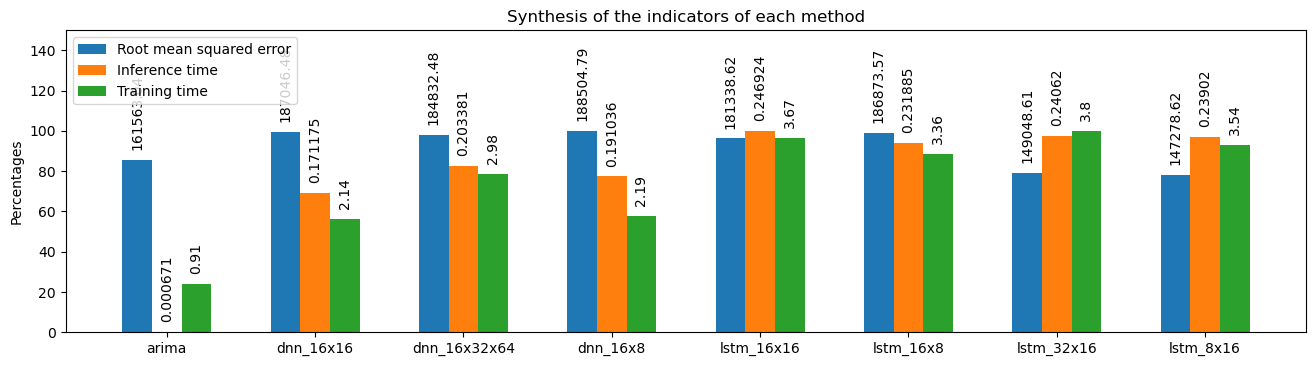

In [5]:
prep = preparation(mean_squared, inference, training)
histo(prep)

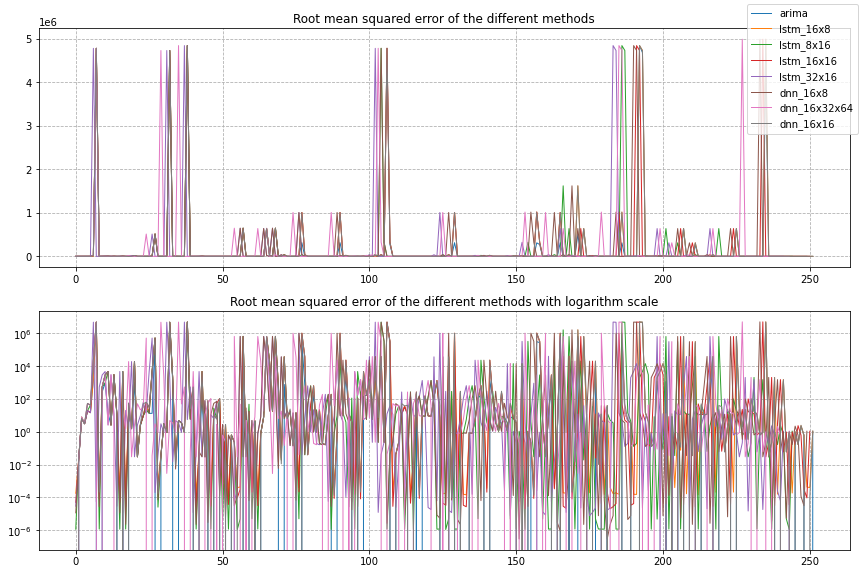

In [6]:
root_mean(dataset, dataname)

In [7]:
string = 'mean_squared_error'
# moustaches(dataset, dataname, string)

In [8]:
val_aber(dataset, string)
for algo in dataset:
    algo.reset_index(inplace=True)
# moustaches(dataset, dataname, string)

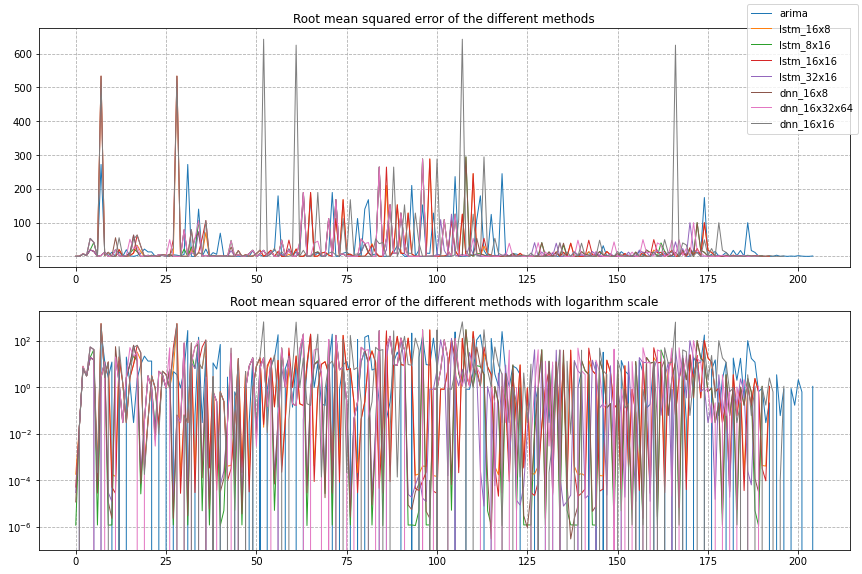

In [9]:
root_mean(dataset, dataname)

In [10]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
lstm_32x16   :        12.88        |        lstm_16x8    :         19.8
lstm_8x16    :        16.28        |        arima        :        20.53
dnn_16x8     :        17.47        |        lstm_16x16   :        21.99
dnn_16x32x64 :        18.22        |        dnn_16x16    :        35.94


In [11]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima        :     0.000629        |        lstm_16x8    :     0.234047
dnn_16x16    :     0.176426        |        lstm_8x16    :     0.243052
dnn_16x8     :     0.197597        |        lstm_32x16   :     0.245069
dnn_16x32x64 :     0.206195        |        lstm_16x16   :     0.246021


In [12]:
training = synthesis(dataset, dataname, 'training_time', 2, True)

Training time comparaison (seconds) :
arima        :         0.92        |        lstm_16x8    :         3.39
dnn_16x16    :         2.18        |        lstm_8x16    :         3.57
dnn_16x8     :         2.24        |        lstm_16x16   :         3.71
dnn_16x32x64 :         3.03        |        lstm_32x16   :         3.83


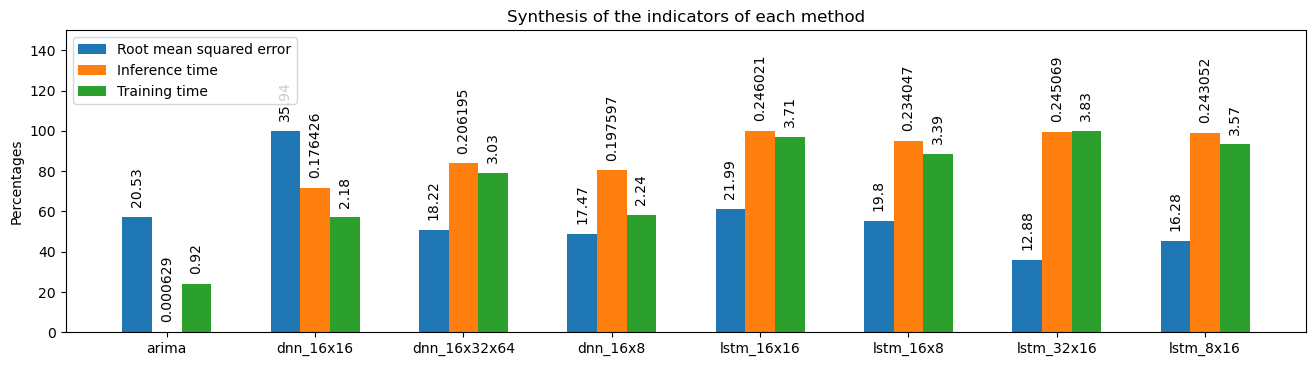

In [13]:
prep = preparation(mean_squared, inference, training)
histo(prep)

In [14]:
dataset, dataname = load_dataset()
extr = val_extr(dataset, string)
for algo in dataset:
    algo.reset_index(inplace=True)
# moustaches(dataset, dataname, string)

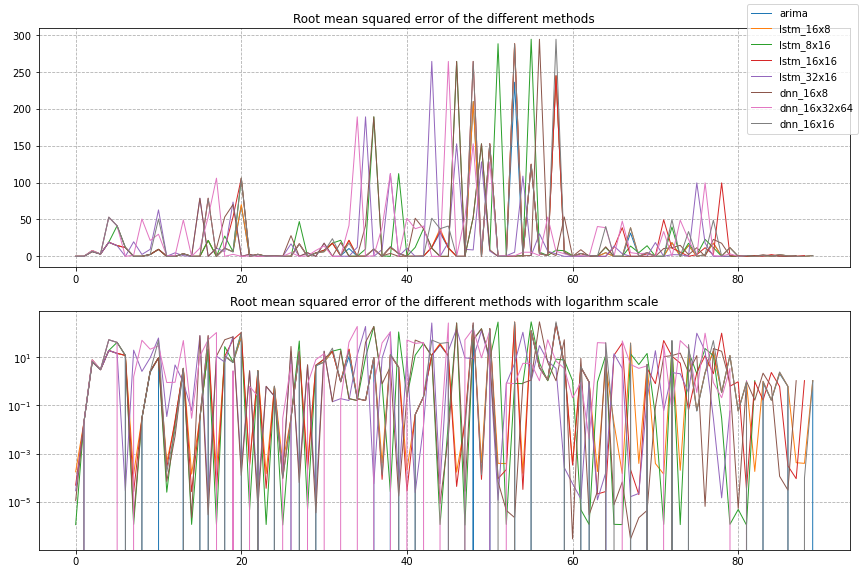

In [15]:
root_mean(dataset, dataname)

In [16]:
mean_squared = synthesis(dataset, dataname, 'mean_squared_error', 2, True)

Mean squared error comparaison :
arima        :        15.72        |        lstm_16x16   :        20.38
lstm_16x8    :        16.65        |        dnn_16x16    :        22.05
dnn_16x8     :        19.44        |        lstm_8x16    :        23.67
lstm_32x16   :        19.97        |        dnn_16x32x64 :        24.56


In [17]:
inference = synthesis(dataset, dataname, 'inference_time', 6, True)

Inference time comparaison (seconds) :
arima        :     0.000678        |        lstm_16x8    :     0.225922
dnn_16x16    :     0.176644        |        lstm_32x16   :     0.227112
dnn_16x8     :     0.190148        |        lstm_16x16   :     0.236079
dnn_16x32x64 :     0.205439        |        lstm_8x16    :     0.241651


In [18]:
training = synthesis(dataset, dataname, 'training_time', 2, True)

Training time comparaison (seconds) :
arima        :         0.91        |        lstm_16x8    :         3.29
dnn_16x8     :         2.11        |        lstm_8x16    :         3.42
dnn_16x16    :         2.14        |        lstm_16x16   :          3.6
dnn_16x32x64 :         2.95        |        lstm_32x16   :          3.6


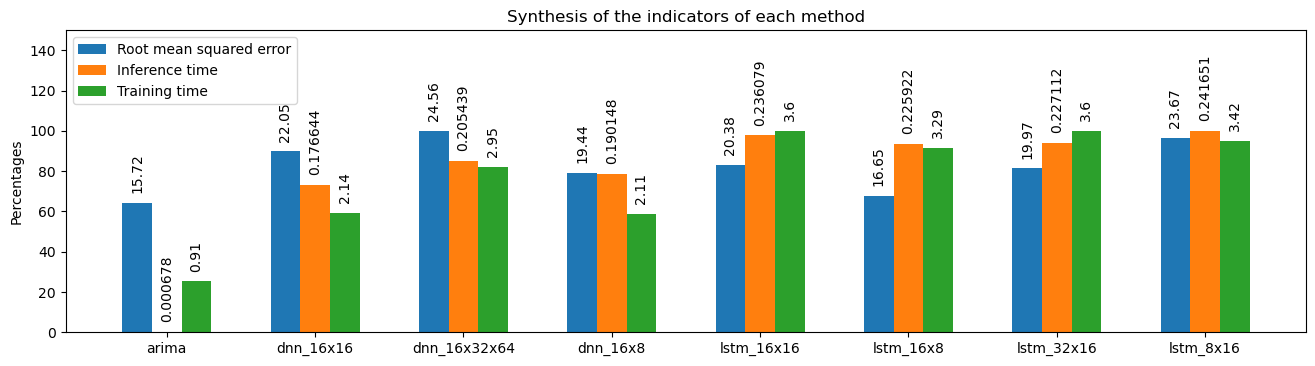

In [19]:
prep = preparation(mean_squared, inference, training)
histo(prep)